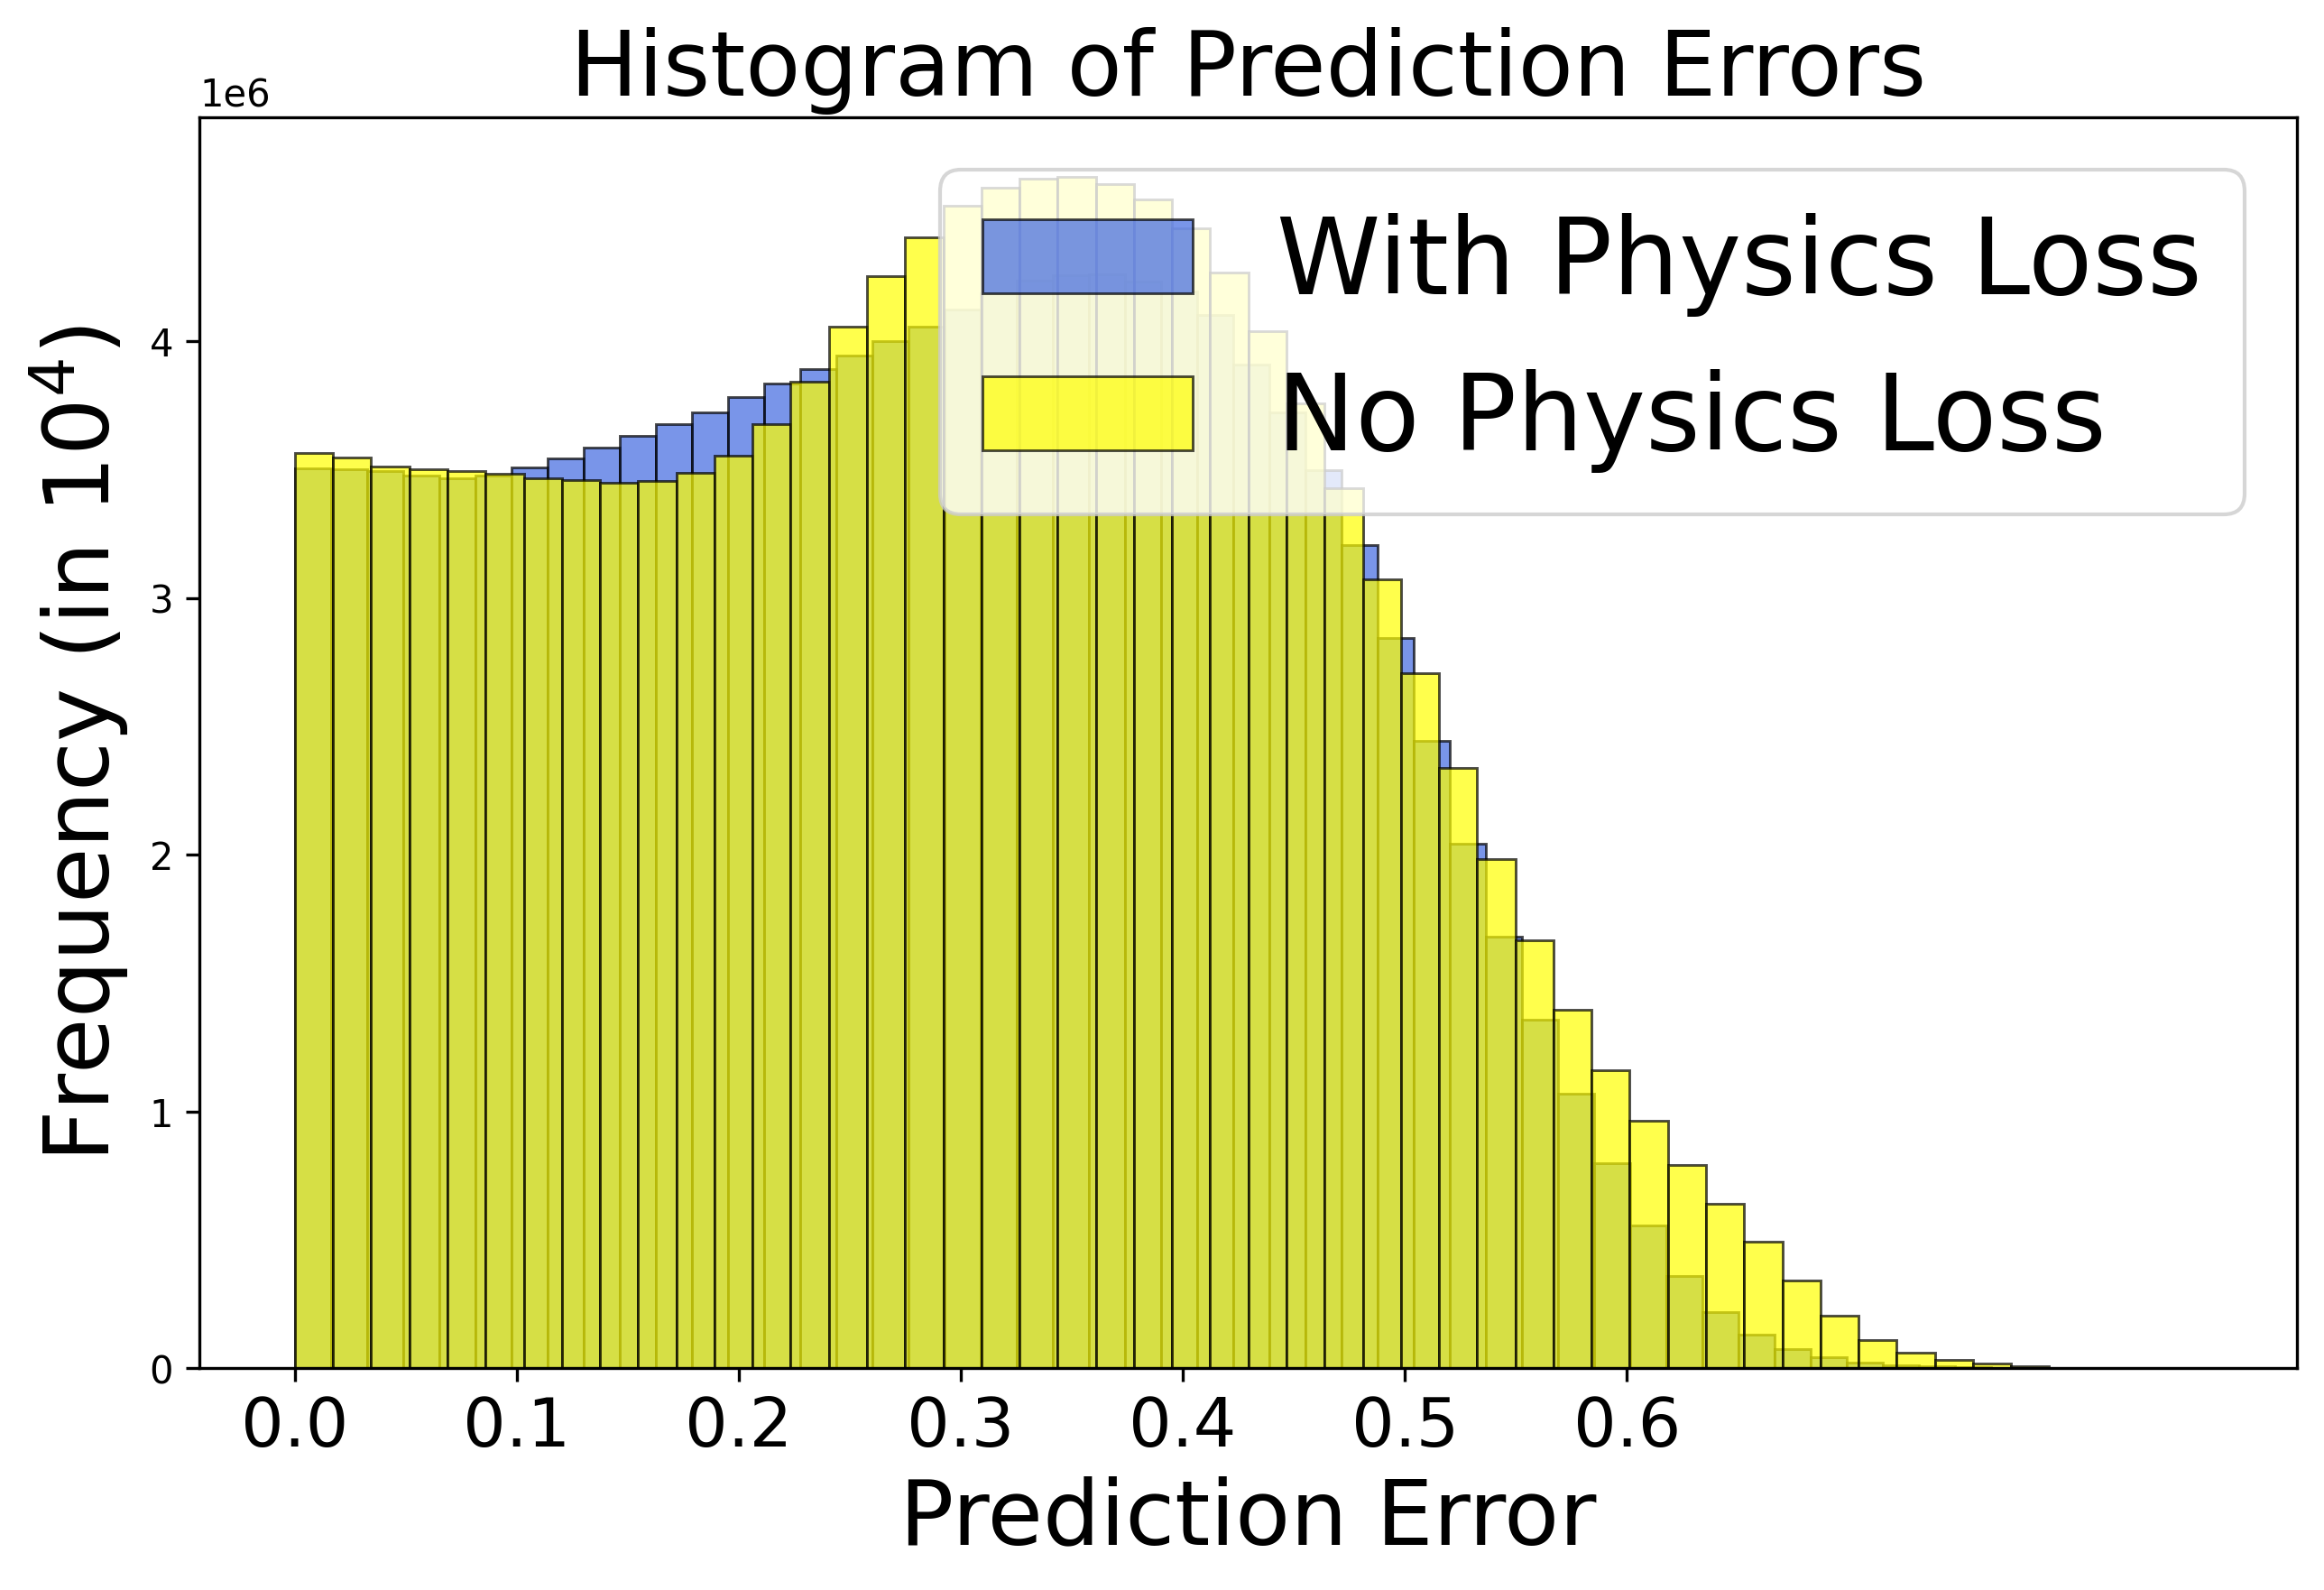

In [17]:
#CycleGAN_1.0 #Voxelscape #For Complete Test Set - Combined
#Combined Error Histogram of with and without Physics Loss from entire folder using Base folder and Subfolder #Voodooed

import os
import torch
from PIL import Image
from generator import Generator
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from transform_utils import  lidar_transform, intensity_sim_transform, incidence_transform, label_transform

binary_transform = transforms.Compose([
    transforms.ToTensor(),
])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_model(folder, in_channel):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = Generator(img_channels=in_channel, out_channels=1) 

    Checkpoint_path = '/DATA2/Vivek/Code/Implementation/CycleGAN/Output_1.0/{folder}/Model/gen_r.pth.tar_{folder}'.format(folder=folder)
    checkpoint = torch.load(Checkpoint_path)

    model.load_state_dict(checkpoint['state_dict'])
    model.to(device)
    model.eval()

    return model

def compute_masked_error(model, filename, input_channel_config):
    
    paths = {img_type: os.path.join(base_path, subfolder, filename) for img_type, subfolder in zip(subfolders, subfolders)}

    # Load the images using the updated paths
    lidar = lidar_transform(Image.open(paths['test_lidar_depth']).convert("L"))
    intensity = intensity_sim_transform(Image.open(paths['test_lidar_intensity']).convert("L"))
    incidence = incidence_transform(Image.open(paths['test_incidence_mask']).convert("L"))
    binary = binary_transform(Image.open(paths['test_binary_mask']).convert("L"))
    label = label_transform(Image.open(paths['test_lidar_label']).convert("L"))

    
    mask_tensor = (binary > 0.5).float()
                                                                                                #Change
    intensity_target = intensity.unsqueeze(0).to(device)

    def inverse_transform(tensor):
        mean = 0.4257
        std = 0.2276
        inv_tensor = tensor * std + mean
        return inv_tensor
    
    #Voxelscape
    if input_channel_config == "T4": #in_channel = 2
        input_data = torch.cat((lidar,incidence), dim=0) 
    elif input_channel_config == "T3": #in_channel = 3
        input_data = torch.cat((binary,incidence,lidar), dim=0)
    elif input_channel_config == "T2":#in_channel = 3
        input_data = torch.cat((lidar,incidence), dim=0)
    else:                     # "T1"  #in_channel = 4
        input_data = torch.cat((binary, label,incidence,lidar), dim=0)

    input_data = input_data.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_data)

    intensity_target = inverse_transform(intensity_target)
    output = inverse_transform(output)

    error = abs(intensity_target - output)
    error_np = error.squeeze().cpu().detach().numpy()

    mask_np = mask_tensor.squeeze().cpu().detach().numpy()
    mask_bool = mask_np > 0
    masked_error_np = np.where(mask_bool, error_np, np.nan)
    
    return masked_error_np

base_path = "/DATA2/Vivek/Data/Trial_3/Test"
subfolders = ['test_lidar_depth', 'test_incidence_mask', 'test_binary_mask', 'test_lidar_intensity', 'test_lidar_label']

folder1 = "T4"  #With Physics Loss
in_channel1 = 2 
model1 = load_model(folder1, in_channel1)  
 
folder2 = "T2" 
in_channel2 = 2
model2 = load_model(folder2, in_channel2)

errors_model1 = []
errors_model2 = []

for filename in os.listdir(os.path.join(base_path, subfolders[0])):
    if filename.endswith('.jpg'):
        masked_error1 = compute_masked_error(model1, filename, folder1)
        masked_error2 = compute_masked_error(model2, filename, folder2)
        
        errors_model1.append(masked_error1)
        errors_model2.append(masked_error2)

# Combine Errors
combined_errors_model1 = np.concatenate(errors_model1)
combined_errors_model2 = np.concatenate(errors_model2)

# Create a combined histogram of the prediction errors
plt.figure(figsize=(10, 6), dpi=300)

# Histogram for With Incidence Angle Mask 
plt.hist(combined_errors_model1.flatten(), bins=50, alpha=0.7, color='royalblue', edgecolor='black', linewidth=0.7, label="With Physics Loss")

# Histogram for No Incidence Angle Mask
plt.hist(combined_errors_model2.flatten(), bins=50, alpha=0.7, color='yellow', edgecolor='black', linewidth=0.7, label="No Physics Loss")


plt.xlabel('Prediction Error', fontsize=24)
x_ticks = np.arange(0, 0.7, 0.1)  # This sets ticks from 0 to 2 in increments of 0.1
plt.xticks(x_ticks, fontsize=18)

order = r'in $10^4$'
# Add a label for the entire y-axis scale with adjusted spacing
plt.ylabel(f"Frequency ({order})", fontsize=24, labelpad=5)

# Add a separate label for 'x 10^4' at the upper left
#plt.text(0.02, 0.95, r'$\times 10^4$', va='center', ha='left', fontsize=18, transform=plt.gca().transAxes)

plt.title('Histogram of Prediction Errors', fontsize=24)
plt.legend(loc='upper right', fontsize=28)

# Set y-ticks with a step size of 10,000 (10^4)
#y_ticks = np.arange(0, 20000001, 4000000)
#plt.yticks(y_ticks, labels=[f"{int(val/10000)}" for val in y_ticks], fontsize=18)

#plt.savefig(f'/DATA2/Vivek/Combined Histogram on Test Set/Incidence Angle/Voxelscape/GAN/{folder1}_{folder2}/Comb_Hist_Test_{folder1}_{folder2}.png')



In [16]:
#CycleGAN #Model trained on VoxelScape prediction on #Kitti
#Prediction from the test folder saving predicted images# Working with entire folder
from transform_utils import lidar_transform,intensity_real_transform,incidence_transform, reflectance_transform, binary_transform
import os
import torch
import numpy as np
from PIL import Image
from generator import Generator
from torchvision.utils import save_image


def process_image(lidar_path, incidence_path, intensity_path, reflectance_path, binary_path, output_folder, gt_output_folder, model, device):
    # Load the input images
    lidar = Image.open(lidar_path).convert("L")
    incidence = Image.open(incidence_path).convert("L")
    intensity = Image.open(intensity_path).convert("L")
    reflectance = Image.open(reflectance_path).convert("L")
    binary = Image.open(binary_path).convert("L")

    # Apply your transformations here...

    lidar = lidar_transform(lidar)
    incidence = incidence_transform(incidence)
    intensity = intensity_real_transform(intensity) 
    reflectance = reflectance_transform(reflectance)
    binary = binary_transform(binary)

    def inverse_transform(tensor):
        mean = 0.4257
        std = 0.2276
        inv_tensor = tensor * std + mean
        return inv_tensor
    

    # Kitti
    #input_data = torch.cat((binary, label,lidar, color, rgb), dim=0)
    #input_data = torch.cat((binary, label,incidence,lidar, color, rgb), dim=0)

    #Voxelscape
    #input_data = torch.cat((lidar,incidence), dim=0) #T4 #in_channels=2
    #input_data = torch.cat((lidar,reflectance), dim=0) #T8 #in_channels=2
    input_data = torch.cat((lidar,incidence, reflectance), dim=0) #T7 #in_channels=3
    #input_data = lidar #T6
    

    input_data = input_data.unsqueeze(0) 

    input_data = input_data.to(device)
    
    with torch.no_grad():
        output = model(input_data)

    output = inverse_transform(output)
    
    

    # Convert the binary mask to a boolean array and apply it to the output tensor
    binary_np = np.array(binary)
    mask = binary_np > 0  # Assuming non-zero values indicate the mask

    # Handle the output tensor
    output_np = output.squeeze().cpu().detach().numpy()
    if output_np.ndim == 2:  # If the output is single-channel
        output_np = np.expand_dims(output_np, axis=0)
    
    # Apply mask
    masked_output = np.where(np.expand_dims(mask, axis=0), output_np, np.nan)

    # Convert NaN values to 0 before saving (adjust this as needed)
    output_ready_for_saving = np.nan_to_num(masked_output, nan=0)

    # Convert back to tensor
    output_tensor = torch.from_numpy(output_ready_for_saving).float()

    # Save the output tensor as an image
    output_file = os.path.join(output_folder, os.path.splitext(os.path.basename(lidar_path))[0] + 'Pred.png')
    save_image(output_tensor, output_file)

    intensity = inverse_transform(intensity)

    # Save the ground truth tensor as an image
    gt_output_file = os.path.join(gt_output_folder, os.path.splitext(os.path.basename(intensity_path))[0] + 'GT' + '.png')
    save_image(intensity, gt_output_file)
    
# specify your input and output directories
Trial = "T7" #Change accordingly
in_channels = 3 #Change accordingly

input_folder = "/DATA2/Vivek/Data/Trial_3/Test/" #Change accordingly
output_folder = f"/DATA2/Vivek/Code/Implementation/CycleGAN/Predicted_Image/Kitti_{Trial}" #Change accordingly
gt_output_folder = output_folder




# Check if the directory exists
if not os.path.exists(output_folder):
    # If it doesn't exist, create it
    os.makedirs(output_folder)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Generator(img_channels=in_channels, out_channels=1)  # Initialize your model architecture
checkpoint = torch.load(f'/DATA2/Vivek/Code/Implementation/CycleGAN/Output_1.0/{Trial}/Model/gen_r.pth.tar_{Trial}')

model.load_state_dict(checkpoint['state_dict'])
model.to(device)
model.eval()

#Iterate over the subdirectories inside the input folder
subfolders = [f for f in os.listdir(input_folder) if os.path.isdir(os.path.join(input_folder, f))]
reference_subfolder = "test_lidar_depth"
reference_files = os.listdir(os.path.join(input_folder, reference_subfolder))

for filename in reference_files:
    if filename.endswith(".jpg"):
        lidar_path = os.path.join(input_folder, "test_lidar_depth", filename)
        incidence_path = os.path.join(input_folder, "test_incidence_mask", filename)
        intensity_path = os.path.join(input_folder, "test_lidar_intensity", filename)
        reflectance_path = os.path.join(input_folder, "test_lidar_reflectance", filename)
        binary_path = os.path.join(input_folder, "test_binary_mask", filename)
        
        process_image(lidar_path, incidence_path, intensity_path, reflectance_path, binary_path, output_folder, gt_output_folder, model, device)



In [31]:
#CycleGAN #Model trained on VoxelScape prediction on #Kitti
#Prediction from the test folder saving predicted images# Working with entire folder
#With Binary Mask
from transform_utils import lidar_transform,intensity_real_transform,incidence_transform, reflectance_transform, binary_transform
import os
import torch
import numpy as np
from PIL import Image
from generator import Generator
from torchvision.utils import save_image


def process_image(lidar_path, incidence_path, intensity_path, reflectance_path, binary_path, output_folder, gt_output_folder, model, device):
    # Load the input images
    lidar = Image.open(lidar_path).convert("L")
    incidence = Image.open(incidence_path).convert("L")
    intensity = Image.open(intensity_path).convert("L")
    reflectance = Image.open(reflectance_path).convert("L")
    binary = Image.open(binary_path).convert("L")

    # Apply your transformations here...

    lidar = lidar_transform(lidar)
    incidence = incidence_transform(incidence)
    intensity = intensity_real_transform(intensity) 
    reflectance = reflectance_transform(reflectance)
    binary = binary_transform(binary)

    def inverse_transform(tensor):
        mean = 0.4257
        std = 0.2276
        inv_tensor = tensor * std + mean
        return inv_tensor
    

    # Kitti
    #input_data = torch.cat((binary, label,lidar, color, rgb), dim=0)
    #input_data = torch.cat((binary, label,incidence,lidar, color, rgb), dim=0)

    #Voxelscape
    #input_data = torch.cat((lidar,incidence), dim=0) #T4 #in_channels=2
    #input_data = torch.cat((lidar,reflectance), dim=0) #T8 #in_channels=2
    #input_data = torch.cat((lidar,incidence, reflectance), dim=0) #T7 #in_channels=3
    #input_data = torch.cat((lidar,reflectance), dim=0) #T8 #in_channels=2
    input_data = lidar #T6


    input_data = input_data.unsqueeze(0) 

    input_data = input_data.to(device)
    
    with torch.no_grad():
        output = model(input_data)

    output = inverse_transform(output)
    
    

    # Convert the binary mask to a boolean array and apply it to the output tensor
    binary_mask = (binary > 0).float()  # Create binary mask from intensity tensor
    binary_mask = binary_mask.to(device)


    # Apply binary mask to the output
    output_masked = output * binary_mask

    # Save the output tensor as an image
    output_file = os.path.join(output_folder, os.path.splitext(os.path.basename(lidar_path))[0] + 'Pred' + '.png')
    save_image(output_masked, output_file)

    # Process and save the intensity image as ground truth
    intensity = inverse_transform(intensity)
    gt_output_file = os.path.join(gt_output_folder, os.path.splitext(os.path.basename(intensity_path))[0] + 'GT' + '.png')
    save_image(intensity, gt_output_file)
    
# specify your input and output directories
Trial = "T6" #Change accordingly
in_channels = 1 #Change accordingly

input_folder = "/DATA2/Vivek/Data/Trial_3/Test/" #Change accordingly
output_folder = f"/DATA2/Vivek/Code/Implementation/CycleGAN/Predicted_Image/Kitti_{Trial}" #Change accordingly
gt_output_folder = output_folder




# Check if the directory exists
if not os.path.exists(output_folder):
    # If it doesn't exist, create it
    os.makedirs(output_folder)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Generator(img_channels=in_channels, out_channels=1)  # Initialize your model architecture
checkpoint = torch.load(f'/DATA2/Vivek/Code/Implementation/CycleGAN/Output_1.0/{Trial}/Model/gen_r.pth.tar_{Trial}')

model.load_state_dict(checkpoint['state_dict'])
model.to(device)
model.eval()

#Iterate over the subdirectories inside the input folder
subfolders = [f for f in os.listdir(input_folder) if os.path.isdir(os.path.join(input_folder, f))]
reference_subfolder = "test_lidar_depth"
reference_files = os.listdir(os.path.join(input_folder, reference_subfolder))

for filename in reference_files:
    if filename.endswith(".jpg"):
        lidar_path = os.path.join(input_folder, "test_lidar_depth", filename)
        incidence_path = os.path.join(input_folder, "test_incidence_mask", filename)
        intensity_path = os.path.join(input_folder, "test_lidar_intensity", filename)
        reflectance_path = os.path.join(input_folder, "test_lidar_reflectance", filename)
        binary_path = os.path.join(input_folder, "test_binary_mask", filename)
        
        process_image(lidar_path, incidence_path, intensity_path, reflectance_path, binary_path, output_folder, gt_output_folder, model, device)



KeyboardInterrupt: 

In [23]:
#CycleGAN #Model trained on VoxelScape prediction on #Kitti
#Prediction from the test folder saving predicted images# Working with entire folder
#binary mask from intensity image
from transform_utils import lidar_transform,intensity_real_transform,incidence_transform, reflectance_transform
import os
import torch
from PIL import Image
from generator import Generator
from torchvision.utils import save_image
from torchvision.transforms.functional import to_tensor, to_pil_image



def process_image(lidar_path, incidence_path, intensity_path, reflectance_path, output_folder, gt_output_folder, model, device):
    # Load the input images
    lidar = Image.open(lidar_path).convert("L")
    incidence = Image.open(incidence_path).convert("L")
    intensity = Image.open(intensity_path).convert("L")
    reflectance = Image.open(reflectance_path).convert("L")


    lidar = lidar_transform(lidar)
    incidence = incidence_transform(incidence)
    intensity = intensity_real_transform(intensity)
    reflectance = reflectance_transform(reflectance)

    def inverse_transform(tensor):
        mean = 0.4257
        std = 0.2276
        inv_tensor = tensor * std + mean
        return inv_tensor
    
    # Create a binary mask from the intensity image
    binary_mask = (intensity > 0).float()  # Create binary mask from intensity tensor
    binary_mask = binary_mask.to(device)

    # Your model input construction here
    input_data = torch.cat((lidar,incidence, reflectance), dim=0) # Example input
    input_data = input_data.unsqueeze(0) 
    input_data = input_data.to(device)
    
    with torch.no_grad():
        output = model(input_data)

    output = inverse_transform(output)

    # Define the default value for zero intensity areas
    default_value = 0.2
    # Prepare a tensor with the default value
    default_tensor = torch.full_like(output, default_value)
    # Use the binary mask to select between the model's output and the default value
    output_masked = output * binary_mask + default_tensor * (1 - binary_mask)

    # Apply binary mask to the output
    #output_masked = output * binary_mask

    # Save the output tensor as an image
    output_file = os.path.join(output_folder, os.path.splitext(os.path.basename(lidar_path))[0] + 'Pred' + '.png')
    save_image(output_masked, output_file)

    # Process and save the intensity image as ground truth
    intensity = inverse_transform(intensity)
    gt_output_file = os.path.join(gt_output_folder, os.path.splitext(os.path.basename(intensity_path))[0] + 'GT' + '.png')
    save_image(intensity, gt_output_file)


# specify your input and output directories
Trial = "T7" #Change accordingly
in_channels = 3 #Change accordingly

input_folder = "/DATA2/Vivek/Data/Trial_3/Test/" #Change accordingly
output_folder = f"/DATA2/Vivek/Code/Implementation/CycleGAN/Predicted_Image/Kitti_{Trial}" #Change accordingly
gt_output_folder = output_folder


# Check if the directory exists
if not os.path.exists(output_folder):
    # If it doesn't exist, create it
    os.makedirs(output_folder)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Generator(img_channels=in_channels, out_channels=1)  # Initialize your model architecture
checkpoint = torch.load(f'/DATA2/Vivek/Code/Implementation/CycleGAN/Output_1.0/{Trial}/Model/gen_r.pth.tar_{Trial}')

model.load_state_dict(checkpoint['state_dict'])
model.to(device)
model.eval()

#Iterate over the subdirectories inside the input folder
subfolders = [f for f in os.listdir(input_folder) if os.path.isdir(os.path.join(input_folder, f))]
reference_subfolder = "test_lidar_depth"
reference_files = os.listdir(os.path.join(input_folder, reference_subfolder))

for filename in reference_files:
    if filename.endswith(".jpg"):
        lidar_path = os.path.join(input_folder, "test_lidar_depth", filename)
        incidence_path = os.path.join(input_folder, "test_incidence_mask", filename)
        intensity_path = os.path.join(input_folder, "test_lidar_intensity", filename)
        reflectance_path = os.path.join(input_folder, "test_lidar_reflectance", filename)

        
        process_image(lidar_path, incidence_path, intensity_path, reflectance_path, output_folder, gt_output_folder, model, device)




KeyboardInterrupt: 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


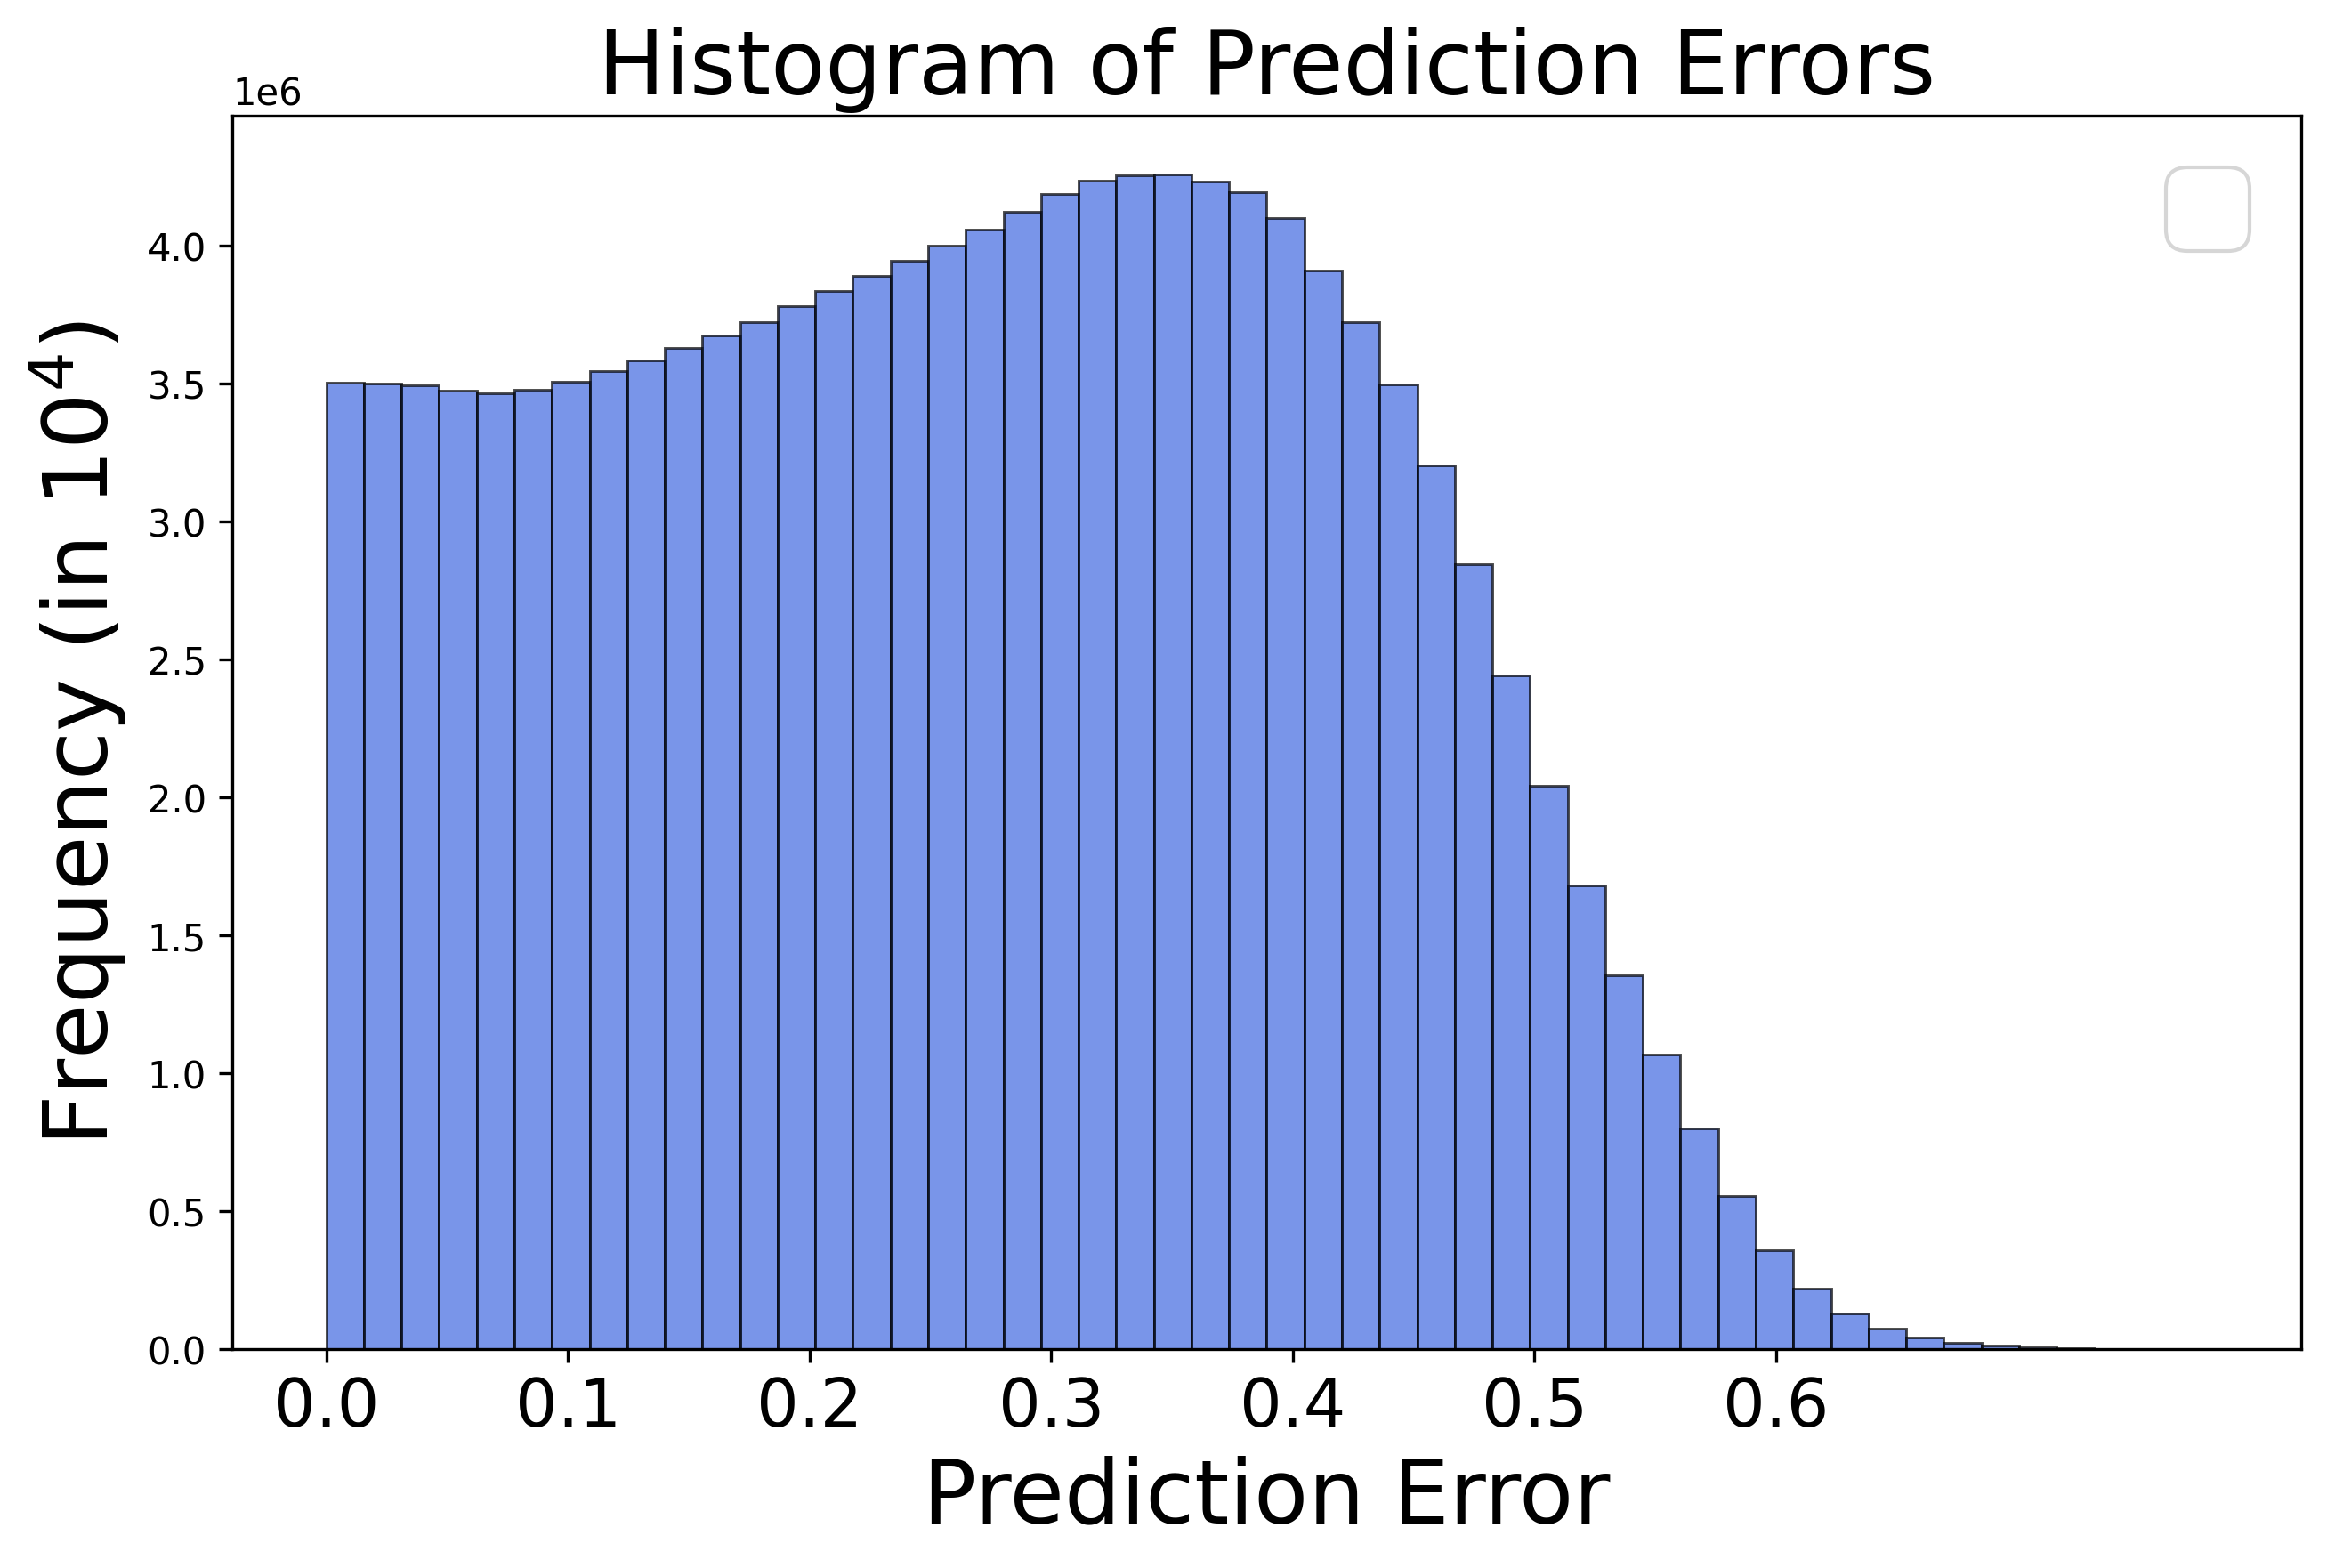

In [29]:
#CycleGAN_1.0 #Voxelscape #For Complete Test Set - Combined
#Combined Error Histogram of with and without Physics Loss from entire folder using Base folder and Subfolder #Voodooed

import os
import torch
from PIL import Image
from generator import Generator
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from transform_utils import  lidar_transform, intensity_sim_transform, incidence_transform, label_transform

binary_transform = transforms.Compose([
    transforms.ToTensor(),
])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_model(folder, in_channel):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = Generator(img_channels=in_channel, out_channels=1) 

    Checkpoint_path = '/DATA2/Vivek/Code/Implementation/CycleGAN/Output_1.0/{folder}/Model/gen_r.pth.tar_{folder}'.format(folder=folder)
    checkpoint = torch.load(Checkpoint_path)

    model.load_state_dict(checkpoint['state_dict'])
    model.to(device)
    model.eval()

    return model

def compute_masked_error(model, filename, input_channel_config):
    
    paths = {img_type: os.path.join(base_path, subfolder, filename) for img_type, subfolder in zip(subfolders, subfolders)}

    # Load the images using the updated paths
    lidar = lidar_transform(Image.open(paths['test_lidar_depth']).convert("L"))
    intensity = intensity_sim_transform(Image.open(paths['test_lidar_intensity']).convert("L"))
    incidence = incidence_transform(Image.open(paths['test_incidence_mask']).convert("L"))
    binary = binary_transform(Image.open(paths['test_binary_mask']).convert("L"))
    label = label_transform(Image.open(paths['test_lidar_label']).convert("L"))
    reflectance = reflectance_transform(Image.open(paths['test_lidar_reflectance']).convert("L"))

    
    mask_tensor = (binary > 0.5).float()
                                                                                                #Change
    intensity_target = intensity.unsqueeze(0).to(device)

    def inverse_transform(tensor):
        mean = 0.2482
        std = 0.2179
        inv_tensor = tensor * std + mean
        return inv_tensor
    
    #Voxelscape
    if input_channel_config == "T4": #in_channel = 2
        input_data = torch.cat((lidar,incidence), dim=0) 
    elif input_channel_config == "T3": #in_channel = 3
        input_data = torch.cat((binary,incidence,lidar), dim=0)
    elif input_channel_config == "T2":#in_channel = 3
        input_data = torch.cat((lidar,incidence), dim=0)
    else:                     # "T1"  #in_channel = 4
        input_data = torch.cat((binary, label,incidence,lidar), dim=0)

    input_data = input_data.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_data)

    intensity_target = inverse_transform(intensity_target)
    output = inverse_transform(output)

    error = abs(intensity_target - output)
    error_np = error.squeeze().cpu().detach().numpy()

    mask_np = mask_tensor.squeeze().cpu().detach().numpy()
    mask_bool = mask_np > 0
    masked_error_np = np.where(mask_bool, error_np, np.nan)
    
    return masked_error_np

base_path = "/DATA2/Vivek/Data/Trial_3/Test"
subfolders = ['test_lidar_depth', 'test_incidence_mask', 'test_binary_mask', 'test_lidar_intensity', 'test_lidar_label', 'test_lidar_reflectance']

folder1 = "T4"  #With Physics Loss
in_channel1 = 2 
model1 = load_model(folder1, in_channel1)  
 
errors_model1 = []


for filename in os.listdir(os.path.join(base_path, subfolders[0])):
    if filename.endswith('.jpg'):
        masked_error1 = compute_masked_error(model1, filename, folder1)

        
        errors_model1.append(masked_error1)


# Combine Errors
combined_errors_model1 = np.concatenate(errors_model1)


# Create a combined histogram of the prediction errors
plt.figure(figsize=(10, 6), dpi=300)

# Histogram for With Incidence Angle Mask 
plt.hist(combined_errors_model1.flatten(), bins=50, alpha=0.7, color='royalblue', edgecolor='black', linewidth=0.7)




plt.xlabel('Prediction Error', fontsize=24)
x_ticks = np.arange(0, 0.7, 0.1)  # This sets ticks from 0 to 2 in increments of 0.1
plt.xticks(x_ticks, fontsize=18)

order = r'in $10^4$'
# Add a label for the entire y-axis scale with adjusted spacing
plt.ylabel(f"Frequency ({order})", fontsize=24, labelpad=5)

# Add a separate label for 'x 10^4' at the upper left
#plt.text(0.02, 0.95, r'$\times 10^4$', va='center', ha='left', fontsize=18, transform=plt.gca().transAxes)

plt.title('Histogram of Prediction Errors', fontsize=24)
plt.legend(loc='upper right', fontsize=28)

# Set y-ticks with a step size of 10,000 (10^4)
#y_ticks = np.arange(0, 20000001, 4000000)
#plt.yticks(y_ticks, labels=[f"{int(val/10000)}" for val in y_ticks], fontsize=18)

#plt.savefig(f'/DATA2/Vivek/Combined Histogram on Test Set/Incidence Angle/Voxelscape/GAN/{folder1}_{folder2}/Comb_Hist_Test_{folder1}_{folder2}.png')

